I am interested in comparing the Homer TF-peak nearest gene promoter and peak location to our ChIP-seq ground truth, which assumes that each peak only regulates the closest gene. The output of `annotatePeaks.pl` is a file for each TF with information about its binding potential to the peaks in your dataset. The columns are:

- PeakID
- Chromosome
- Peak start position
- Peak end position
- Strand
- Peak Score
- FDR/Peak Focus Ratio/Region Size
- Annotation (i.e. Exon, Intron, ...)
- Detailed Annotation (Exon, Intron etc. + CpG Islands, repeats, etc.)
- Distance to nearest RefSeq TSS
- Nearest TSS: Native ID of annotation file
- Nearest TSS: Entrez Gene ID
- Nearest TSS: Unigene ID
- Nearest TSS: RefSeq ID
- Nearest TSS: Ensembl ID
- Nearest TSS: Gene Symbol
- Nearest TSS: Gene Aliases
- Nearest TSS: Gene description
- Additional columns depend on options selected when running the program.

I am interested in the following columns:

- PeakID
- Chromosome
- Peak start position
- Peak end position
- Annotation (i.e. Exon, Intron, ...)
- Detailed Annotation (Exon, Intron etc. + CpG Islands, repeats, etc.)
- Distance to nearest RefSeq TSS
- Nearest TSS: Gene Symbol
- CpG%
- GC%

The TF name can be found in the final column, which is structure as:

> CTCF(Zf)/CD4+-CTCF-ChIP-Seq(Barski_et_al.)/Homer Distance From Peak(sequence,strand,conservation)

There is some information in the literature that the likelihood of peaks regulating the nearest TSS is different based on the location of the peak, such as introns, promoter/TSS, intergenic, etc.

Homer stores each TF's peak binding as a separate file. The TF name can be parsed from the last column name. We first build a DataFrame from the Homer `annotatePeak` output file containing the columns of interest.

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from typing import Tuple

from grn_inference.plotting import plot_enhancer_to_target_arcs

data_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/sample_data/"

homer_df = pd.read_csv(
    os.path.join(data_dir, "sample_homer_annotatePeak_output.tsv"), 
    sep="\t", 
    header=0, 
    index_col=0 # Setting the PeakID column as the index
    )
homer_df.index.names = ["PeakID"]

TF_name = homer_df.columns[-1].split('/')[0].split('(')[0].split(':')[0].upper()

homer_df["peak_id"] = homer_df["Chr"].astype(str) + ":" + homer_df["Start"].astype(str) + "-" + homer_df["End"].astype(str)
homer_df["source_id"] = TF_name
homer_df = homer_df.rename(columns={"Gene Name":"target_id"})

cols_of_interest = [
    "source_id",
    "peak_id",
    "target_id",
    "Chr",
    "Start",
    "End",
    "Annotation",
    "Distance to TSS",
    "Gene Type",
    "CpG%",
    "GC%"
]
homer_df = homer_df[cols_of_interest]
homer_df["target_id"] = homer_df["target_id"].str.upper()
homer_df.head()

,source_id,peak_id,target_id,Chr,Start,End,Annotation,Distance to TSS,Gene Type,CpG%,GC%
PeakID,,,,,,,,,,,
peak75613,CTCF,chr16:93932426-93933224,CLDN14,chr16,93932426,93933224,"intron (NM_019500, intron 2 of 2)",-3008,protein-coding,0.018797,0.518148
peak17901,CTCF,chr10:67284946-67285839,NRBF2,chr10,67284946,67285839,promoter-TSS (NM_001036293),-111,protein-coding,0.081747,0.633110
peak151815,CTCF,chr6:98435152-98436223,MDFIC2,chr6,98435152,98436223,Intergenic,-92933,protein-coding,0.014006,0.455224
peak52902,CTCF,chr13:113270778-113271469,CSPG4B,chr13,113270778,113271469,Intergenic,-22047,protein-coding,0.011577,0.455202
peak34483,CTCF,chr11:114764860-114765741,KIF19A,chr11,114764860,114765741,promoter-TSS (NM_001102615),-89,protein-coding,0.057889,0.626984


Now we can extract the different targets for the TF predicted by Homer.

In [10]:
tf_to_nearest_gene = homer_df[["source_id", "target_id"]].reset_index(drop=True).drop_duplicates()
tf_to_nearest_gene.head()

,source_id,target_id
0,CTCF,CLDN14
1,CTCF,NRBF2
2,CTCF,MDFIC2
3,CTCF,CSPG4B
4,CTCF,KIF19A


We can show the enhancers that are predicted to interact with a given target gene

The mm10 tss_reference_file can be downloaded from here:

[RefGenie mm10 TSS annotation file](http://awspds.refgenie.databio.org/refgenomes.databio.org/0f10d83b1050c08dd53189986f60970b92a315aa7a16a6f1/ensembl_gtf__default/0f10d83b1050c08dd53189986f60970b92a315aa7a16a6f1_ensembl_gene_body.bed)

The mm10 gene_body_anno_file can be downloaded from here:

[RefGenie mm10 gene body annotation file](http://awspds.refgenie.databio.org/refgenomes.databio.org/0f10d83b1050c08dd53189986f60970b92a315aa7a16a6f1/ensembl_gtf__default/0f10d83b1050c08dd53189986f60970b92a315aa7a16a6f1_ensembl_gene_body.bed)

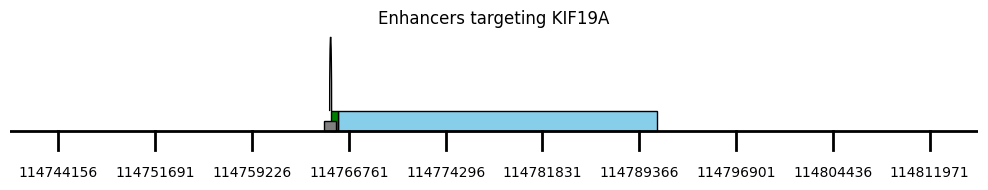

In [49]:
tss_reference_file = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/genome_annotation/mm10/mm10_TSS.bed"
gene_body_anno_file = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/genome_annotation/mm10/mm10_gene_body_anno.bed"
plot_enhancer_to_target_arcs(homer_df, "KIF19A", tss_reference_file, gene_body_anno_file)